# Steel Plate Defect prediction


## Preparing train set

In [27]:
import pandas as pd
import numpy as np
from sklearn import model_selection
path = 'input/'

TARGET = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

if __name__ == "__main__":
    # Training data is in the "train.csv" and "faults.csv" files
    train_data = pd.read_csv(path + 'train.csv')
    original_data = pd.read_csv(path + 'faulty-steel-plates/faults.csv')
    train_data.drop('id', axis=1, inplace=True)
    train_data = pd.concat([train_data, original_data], axis=0)

    # drop mult label data points
    train_data = train_data[train_data[TARGET].sum(axis=1) <= 1]
    train_data['Outside_Global_Index'] = np.where(train_data['Outside_Global_Index']==0.7, 0.5, train_data['Outside_Global_Index'])

    train_data['target'] = np.argmax(train_data[TARGET].values, axis=1) + 1
    train_data.loc[train_data[TARGET].sum(axis=1) == 0, 'target'] = 0
    train_data.drop(TARGET, axis=1, inplace=True)

    # we create a new column called kfold and fill it with -1
    train_data['kfold'] = -1

    # the next step is to randomize the rows of the data
    train_data = train_data.sample(frac=1).reset_index(drop=True)

    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=5)

    # fill the new kfold column
    for f, (t_, v_) in enumerate(kf.split(X=train_data, y=train_data['target'].values)):
        train_data.loc[v_, 'kfold'] = f
    
    # save the new csv with kfold column
    train_data.to_csv(path + 'train_folds.csv', index=False)


    

    

## Classification of Steel Plate Defect dataset with tree-base models (baseline)

* [Extreme Gradient Booster (Random Forest)](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

* [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)

* [CatBoost](https://catboost.ai/)

### Read dataset and check the distribution of target variables

In [1]:
import pandas as pd

df = pd.read_csv('input/train_folds.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21139 entries, 0 to 21138
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              21139 non-null  int64  
 1   X_Maximum              21139 non-null  int64  
 2   Y_Minimum              21139 non-null  int64  
 3   Y_Maximum              21139 non-null  int64  
 4   Pixels_Areas           21139 non-null  int64  
 5   X_Perimeter            21139 non-null  int64  
 6   Y_Perimeter            21139 non-null  int64  
 7   Sum_of_Luminosity      21139 non-null  int64  
 8   Minimum_of_Luminosity  21139 non-null  int64  
 9   Maximum_of_Luminosity  21139 non-null  int64  
 10  Length_of_Conveyer     21139 non-null  int64  
 11  TypeOfSteel_A300       21139 non-null  int64  
 12  TypeOfSteel_A400       21139 non-null  int64  
 13  Steel_Plate_Thickness  21139 non-null  int64  
 14  Edges_Index            21139 non-null  float64
 15  Em

In [2]:
df['target'].value_counts()

target
7    7213
6    5163
3    3802
1    1623
2    1340
0     818
4     640
5     540
Name: count, dtype: int64

In [3]:
def model_assess(model, title='Default'):
    model.fit(X_train, y_train)
    # Predict class probabilities
    y_proba = model.predict_proba(X_test)

    # Compute the AUC for each class and take the average
    average_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    print(f'{title} Average AUC: {average_auc}')
    return average_auc

    


In [7]:
import pandas as pd
import time
import lightgbm as lgb
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

SEED = 42
xgb_results = []
cat_results = []
lgbm_results = []

for fold in range(5):
    print(f'Processing fold {fold}')
    df = pd.read_csv('input/train_folds.csv')
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_test = df[df.kfold == fold].reset_index(drop=True)

    X_train = df_train.drop(['target', 'kfold'], axis=1)
    y_train = df_train['target']

    X_test = df_test.drop(['target', 'kfold'], axis=1)
    y_test = df_test['target']

    # Extreme Gradient Boosting Classifier
    start_time = time.time()
    xgb = XGBClassifier(random_state=SEED, device='gpu')
    xgb_auc = model_assess(xgb, 'XGBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    xgb_results.append(xgb_auc)
    print(f'Execution time for XGBoost: {execution_time:.2f} seconds')

    # CatBoost Classifier
    start_time = time.time()
    cat = CatBoostClassifier(random_state=SEED, verbose=False, task_type='GPU', allow_writing_files=False)
    cat_auc = model_assess(cat, 'CatBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    cat_results.append(cat_auc)
    print(f'Execution time for CatBoost: {execution_time:.2f} seconds')

    # LightGBM Classifier
    start_time = time.time()
    lgbm = lgb.LGBMClassifier(random_state=SEED, device='gpu', verbose=0)
    lgbm_auc = model_assess(lgbm, 'LightGBM')
    end_time = time.time()
    execution_time = end_time - start_time
    lgbm_results.append(lgbm_auc)
    print(f'Execution time for LightGBM: {execution_time:.2f} seconds')

    print('-'*50)

print(f'Average XGBoost AUC: {np.mean(xgb_results)}')
print(f'Average CatBoost AUC: {np.mean(cat_results)}')
print(f'Average LightGBM AUC: {np.mean(lgbm_results)}')
    

Processing fold 0
XGBoost Average AUC: 0.8586832118510552
Execution time for XGBoost: 6.90 seconds
CatBoost Average AUC: 0.8649960107272939
Execution time for CatBoost: 17.16 seconds
LightGBM Average AUC: 0.8598581668227699
Execution time for LightGBM: 7.85 seconds
--------------------------------------------------
Processing fold 1
XGBoost Average AUC: 0.8546527862446336
Execution time for XGBoost: 4.48 seconds
CatBoost Average AUC: 0.8625416418390057
Execution time for CatBoost: 14.44 seconds
LightGBM Average AUC: 0.8581122899913534
Execution time for LightGBM: 6.95 seconds
--------------------------------------------------
Processing fold 2
XGBoost Average AUC: 0.8522447318088513
Execution time for XGBoost: 3.20 seconds
CatBoost Average AUC: 0.8533285237635493
Execution time for CatBoost: 11.50 seconds
LightGBM Average AUC: 0.8604471048523936
Execution time for LightGBM: 8.60 seconds
--------------------------------------------------
Processing fold 3
XGBoost Average AUC: 0.85510709

Analysing the cross-fold validation, LightGBM and CatBoost had the best overall results.

## Applying All Relevant Features Selections (([ARFS](https://github.com/ThomasBury/arfs))) to the dataset

### GrootCV



























Repeated k-fold: 100%|██████████| 25/25 [11:57<00:00, 28.69s/it]


The selected features: ['Outside_X_Index' 'Edges_Y_Index']
The agnostic ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1]
The naive ranking: ['Edges_Y_Index', 'Outside_X_Index', 'LogOfAreas', 'Length_of_Conveyer', 'Luminosity_Index', 'Empty_Index', 'Orientation_Index', 'Edges_Index', 'Log_X_Index', 'ShadowVar16', 'ShadowVar17', 'Edges_X_Index', 'ShadowVar2', 'Minimum_of_Luminosity', 'ShadowVar15', 'ShadowVar18', 'ShadowVar1', 'ShadowVar19', 'ShadowVar10', 'Log_Y_Index', 'ShadowVar11', 'Pixels_Areas', 'Maximum_of_Luminosity', 'ShadowVar14', 'ShadowVar12', 'ShadowVar13', 'Outside_Global_Index']


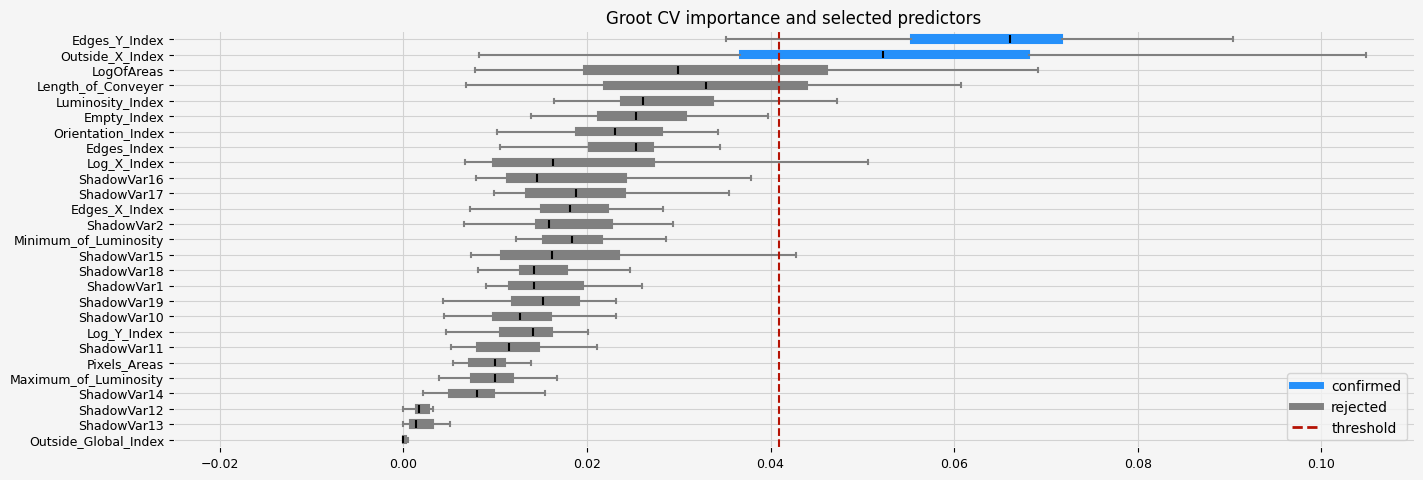

In [9]:
import pandas as pd
import lightgbm as lgb
import arfs.feature_selection.allrelevant as arfsgroot
import matplotlib as mpl
import matplotlib.pyplot as plt
import json

from arfs.benchmark import highlight_tick

%matplotlib inline

df = pd.read_csv('input/train_folds.csv')
X = df.drop(['target', 'kfold'], axis=1)
y = df['target']

model = lgb.LGBMClassifier(random_state=42, device='gpu', verbose=0)

grootcv_feat_selector = arfsgroot.GrootCV(objective='multiclass', cutoff=1, n_folds=5, n_iter=5, silent=True, fastshap=False, n_jobs=0, lgbm_params={'device': 'gpu', 'gpu_device_id': 1})
grootcv_feat_selector.fit(X, y, sample_weight=None)

print(f"The selected features: {grootcv_feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {grootcv_feat_selector.ranking_}")
print(f"The naive ranking: {grootcv_feat_selector.ranking_absolutes_}")
fig = grootcv_feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

grootcv_selected_features = grootcv_feat_selector.get_feature_names_out()

json_file_path = 'groot_cv_selected_features.json'
with open(json_file_path, 'w') as f:
    json.dump(grootcv_selected_features.tolist(), f)

In [20]:
import pandas as pd
import time
import lightgbm as lgb
import numpy as np
import json
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

SEED = 42
xgb_results = []
cat_results = []
lgbm_results = []

json_file_path = 'groot_cv_selected_features.json'

# Load the selected features from the JSON file
with open(json_file_path, 'r') as json_file:
    selected_features = json.load(json_file)

print(f'selected features from GrootCV: {selected_features}')
for fold in range(5):
    print(f'Processing fold {fold}')
    df = pd.read_csv('input/train_folds.csv')
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_test = df[df.kfold == fold].reset_index(drop=True)

    X_train = df_train[selected_features]
    y_train = df_train['target']

    X_test = df_test[selected_features]
    y_test = df_test['target']

    # Extreme Gradient Boosting Classifier
    start_time = time.time()
    xgb = XGBClassifier(random_state=SEED, device='gpu')
    xgb_auc = model_assess(xgb, 'XGBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    xgb_results.append(xgb_auc)
    print(f'Execution time for XGBoost: {execution_time:.2f} seconds')

    # CatBoost Classifier
    start_time = time.time()
    cat = CatBoostClassifier(random_state=SEED, verbose=False, task_type='GPU', allow_writing_files=False)
    cat_auc = model_assess(cat, 'CatBoost')
    end_time = time.time()
    execution_time = end_time - start_time
    cat_results.append(cat_auc)
    print(f'Execution time for CatBoost: {execution_time:.2f} seconds')

    # LightGBM Classifier
    start_time = time.time()
    lgbm = lgb.LGBMClassifier(random_state=SEED, device='gpu', verbose=0)
    lgbm_auc = model_assess(lgbm, 'LightGBM')
    end_time = time.time()
    execution_time = end_time - start_time
    lgbm_results.append(lgbm_auc)
    print(f'Execution time for LightGBM: {execution_time:.2f} seconds')

    print('-'*50)

print(f'Average XGBoost AUC: {np.mean(xgb_results)}')
print(f'Average CatBoost AUC: {np.mean(cat_results)}')
print(f'Average LightGBM AUC: {np.mean(lgbm_results)}')

selected features from GrootCV: ['Outside_X_Index', 'Edges_Y_Index']
Processing fold 0
XGBoost Average AUC: 0.7411524110782949
Execution time for XGBoost: 3.48 seconds
CatBoost Average AUC: 0.7518728193846091
Execution time for CatBoost: 14.11 seconds
LightGBM Average AUC: 0.7450310543399359
Execution time for LightGBM: 6.99 seconds
--------------------------------------------------
Processing fold 1
XGBoost Average AUC: 0.7398853804452838
Execution time for XGBoost: 3.10 seconds
CatBoost Average AUC: 0.7513501938649909
Execution time for CatBoost: 9.82 seconds
LightGBM Average AUC: 0.7424953294433683
Execution time for LightGBM: 6.67 seconds
--------------------------------------------------
Processing fold 2
XGBoost Average AUC: 0.7513178336479928
Execution time for XGBoost: 3.99 seconds
CatBoost Average AUC: 0.7540789380917885
Execution time for CatBoost: 12.77 seconds
LightGBM Average AUC: 0.7521410635198145
Execution time for LightGBM: 7.14 seconds
--------------------------------

### Leshy

In [8]:
import lightgbm as lgb
import pandas as pd
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench

df = pd.read_csv('input/train_folds.csv')
X = df.drop(['target', 'kfold'], axis=1)
y = df['target']
SEED = 42

model = XGBClassifier(random_state=SEED, device='gpu')
feat_selector = arfsgroot.Leshy(model, verbose=1)
feat_selector.fit(X, y, sample_weight=None)
print(f'The selected features are: {feat_selector.selected_features_}, {type(feat_selector.selected_features_)}')
print(f'The agnostic ranking: {feat_selector.ranking_}, {type(feat_selector.ranking_)}')
print(f'The naive ranking: {feat_selector.ranking_absolutes_}, {type(feat_selector.ranking_absolutes_)}')
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

ValueError: shape mismatch: value array of shape (27,8) could not be broadcast to indexing result of shape (27,)

### BoostAGroota

In [3]:
import lightgbm as lgb
import pandas as pd
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
import matplotlib.pyplot as plt
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from sklearn.base import clone

from xgboost import XGBClassifier

df = pd.read_csv('input/train_folds.csv')

X = df.drop(['target', 'kfold'], axis=1)
y = df['target']

model = XGBClassifier(random_state=42)

feat_selector = arfsgroot.BoostAGroota(estimator=model, cutoff=1, max_rounds=10, delta=0.1)
feat_selector.fit(X, y, sample_weight=None)
print(f'The selected features are: {feat_selector.selected_features_}, {type(feat_selector.selected_features_)}')
print(f'The agnostic ranking: {feat_selector.ranking_}, {type(feat_selector.ranking_)}')
print(f'The naive ranking: {feat_selector.ranking_absolutes_}, {type(feat_selector.ranking_absolutes_)}')
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

Only Sklearn tree based methods allowed
Only Sklearn tree based methods allowed
Only Sklearn tree based methods allowed
Only Sklearn tree based methods allowed
Only Sklearn tree based methods allowed
Only Sklearn tree based methods allowed
Only Sklearn tree based methods allowed
Only Sklearn tree based methods allowed
Only Sklearn tree based methods allowed


BoostaGRoota round:   0%|          | 0/10 [06:53<?, ?it/s]

Only Sklearn tree based methods allowed
The selected features are: [], <class 'numpy.ndarray'>
The agnostic ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], <class 'numpy.ndarray'>
The naive ranking: ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas'], <class 'list'>



c:\Users\Rafael\miniconda3\Lib\site-packages\arfs\feature_selection\allrelevant.py:1641: UserWarning: No feature selected - No data to plot
  warnings.warn(NO_FEATURE_SELECTED_WARNINGS)


AttributeError: 'NoneType' object has no attribute 'gca'